In [102]:
import pandas as pd
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from sklearn.preprocessing import StandardScaler

In [115]:
sigma_line = query_table(table='uv_sigma_line_eg_5T')

In [116]:
px.line(
    x=sigma_line.index, y=sigma_line.kw, 
    title='UV Sigma Line',
    labels={
        'x': 'Time',
        'y': 'kW'
    })

In [117]:
sigma = sigma_line[(sigma_line.index.day >= 12) & (sigma_line.index.day < 17)] ## for pedagoical reasons
day_range = sigma.index.max() - sigma.index.min()

In [119]:
sigma_final = pd.DataFrame(data=sigma['kw'], index=sigma.index)
sigma_final.reset_index(inplace=True)

# Scaling helps with convergence via MCMC
scale = StandardScaler()
sigma_final['kw'] = scale.fit_transform(sigma_final['kw'].values.reshape(-1, 1))

sigma_test = sigma_line[sigma_line.index.day >= 17]
sigma_test_final = pd.DataFrame(data=sigma_test['kw'], index=sigma_test.index)

In [120]:
sigma_final = sigma_final.rename(columns={'t': 'ds', 'kw': 'y'})
sigma_test_final = sigma_test_final.rename(columns={'t': 'ds', 'kw': 'y'})

In [121]:
sigma_final

,ds,y
0,2021-10-12 00:00:00,-1.826331
1,2021-10-12 00:05:00,-0.236752
2,2021-10-12 00:10:00,0.397035
3,2021-10-12 00:15:00,0.453625
4,2021-10-12 00:20:00,0.346336
...,...,...
1435,2021-10-16 23:35:00,0.024690
1436,2021-10-16 23:40:00,0.944563
1437,2021-10-16 23:45:00,1.112203
1438,2021-10-16 23:50:00,0.747181


In [122]:
m = Prophet(
    changepoint_prior_scale=5,
)

# Add custom seasonality which isn't pre-built
m.add_seasonality(name='hourly', period=0.05, fourier_order=50)

m.fit(sigma_final)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -416.96


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       602.134     0.0105345       2.29942           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       602.214   0.000133147        1.8383   6.448e-05       0.001      248  LS failed, Hessian reset 
     199       602.233   0.000758657       1.84511      0.4378      0.4378      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       602.245   8.96519e-05        1.2174   4.673e-05       0.001      392  LS failed, Hessian reset 
     299       602.247    0.00012876       0.82367      0.2651           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       602.255   0.000157565       1.48087   8.886e-05       0.001      516  LS failed, Hessian reset 
     399       602.268   0.000436053  

In [123]:
future = pd.DataFrame(
    data=pd.date_range('2021-10-12 00:00:00', '2021-10-17 23:50:00', freq='5T'),
    columns=['ds']
    )

In [124]:
forecast = m.predict(future)

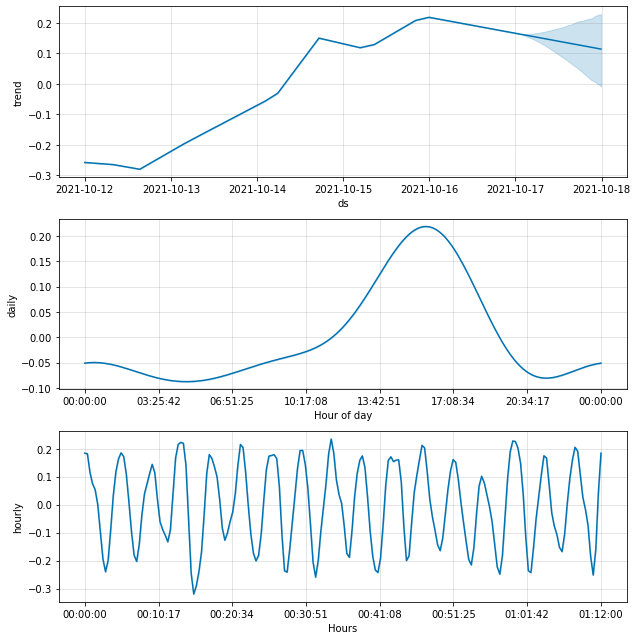

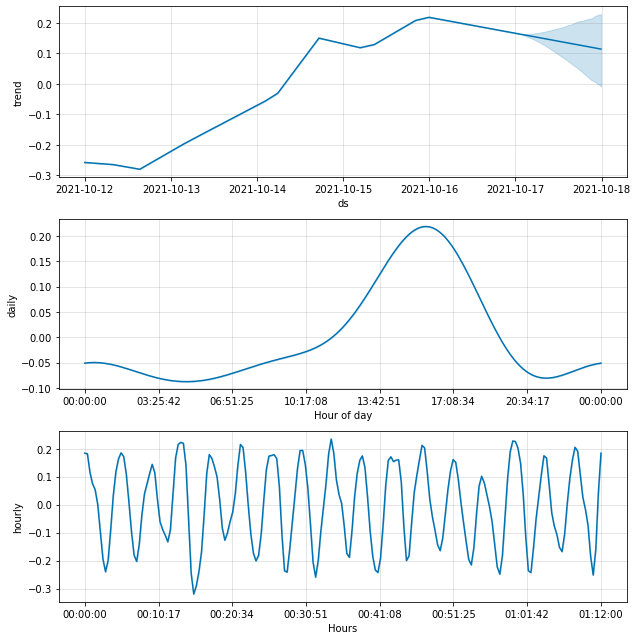

In [125]:
m.plot_components(forecast)

In [126]:
import plotly
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)